# Exercise 1: Classifying penguin species with PyTorch

<img src="https://allisonhorst.github.io/palmerpenguins/reference/figures/lter_penguins.png" width="750" />


Artwork by @allison_horst

In this exercise, we will use the python package [``palmerpenguins``](https://github.com/mcnakhaee/palmerpenguins) to supply a toy dataset containing various features and measurements of penguins.

The penguin datset is a set of real-life observations collected from a research centre called Palmer Station in Antarctica by Dr. Kristen Gorman. The dataset consists of 7 variables, out of which 4 are numerical and 3 are categorical which we will see just now. The task here is to classify penguins' species based on their physical characteristics and a few other variables that might help the classification.  

We have already created a PyTorch dataset which yields data for each of the penguins, but first we should examine the dataset and see what it contains.

### Task 1: look at the data
In the following code block, we import the ``load_penguins`` function from the ``palmerpenguins`` package.

- Call this function, which returns a single object in the form of a ``pandas.DataFrame``, and assign it to the variable ``data``.
  - Print ``data`` and recognise that ``load_penguins`` has returned the dataframe.
- Consider which features it might make sense to use in order to classify the species of the penguins.
  - You can print the column names using ``pd.DataFrame.keys()``
  - You can also obtain useful statistical information on the dataset using ``pd.DataFrame.Series.describe()``

In [41]:
from palmerpenguins import load_penguins

data = load_penguins()

print(data.head())

# print(data.keys())

  species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
3  Adelie  Torgersen             NaN            NaN                NaN   
4  Adelie  Torgersen            36.7           19.3              193.0   

   body_mass_g     sex  year  
0       3750.0    male  2007  
1       3800.0  female  2007  
2       3250.0  female  2007  
3          NaN     NaN  2007  
4       3450.0  female  2007  


In [42]:
# Note: ``pd.DataFrame.describe`` is a useful function for giving an overview
# of what a ``pd.DataFrame`` contains.
print(data.describe())

       bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g  \
count      342.000000     342.000000         342.000000   342.000000   
mean        43.921930      17.151170         200.915205  4201.754386   
std          5.459584       1.974793          14.061714   801.954536   
min         32.100000      13.100000         172.000000  2700.000000   
25%         39.225000      15.600000         190.000000  3550.000000   
50%         44.450000      17.300000         197.000000  4050.000000   
75%         48.500000      18.700000         213.000000  4750.000000   
max         59.600000      21.500000         231.000000  6300.000000   

              year  
count   344.000000  
mean   2008.029070  
std       0.818356  
min    2007.000000  
25%    2007.000000  
50%    2008.000000  
75%    2009.000000  
max    2009.000000  


Let's now discuss the features we will use to classify the penguins' species, and populate the following list together:

#### Let's use:

- ``"bill_length_mm"``
    - Biologically relevant and unambiguous.
- ``"bill_depth_mm"``
    - Biologically relevant.
- ``flipper_length_mm``
    - Biologically relevant.
- ``"body_mass_g"``
    - Biologically relevant.
- ``"sex"``
    - While a potential source of bias, it is likely informative and biologically relevant.

#### Let's reject
- ``"island"``
    - While island is likely to be predictive, it seems potentially misleading to use this feature. One island could be heavily dominated by one species of penguin, while other species abide there in much smaller numbers. Such a situation could result in a model giving too much weight to this feature, and confounding the results. 
- ``"year"``
    - This feature could also be important: then behaviour of certain species may be changing in response to time-dependent environmental factors such as melting ice. It does however seem like the least biologically-relevant feature, and the most likely source of bias, so we reject it.

### Task 2: creating a ``torch.utils.data.Dataset``

To be able to use Pytorch functionalities, we need to make the dataset compatible with Pytorch. We do it using PyTorch's Dataset class called ``torch.utils.data.Dataset``. 

To make a custom dataset, create a new class which inherits from the ``Dataset`` class, implement some methods (the Python magic (or dunder) like ``__len__`` and ``__getitem__``) and supply data.

Spoiler alert: we've done this for you already in ``src/ml_workshop/_penguins.py``.

- Open the above mentioned file.
- Let's examine, and discuss, each of the methods together.
  - ``__len__``
    - What does the ``__len__`` method do?
      - The ``__len__`` method is a so-called "magic method" in python, that defines what happens when the ``len`` function is called on an object.
  - ``__getitem__``
    - What does the ``__getitem__`` method do?
      - The ``__getitem__`` method is another magic method which tells python what to do if we try and index the object containing it (i.e. ``my_object[idx]``).
- Review and discuss the class arguments.
  - ``input_keys``— A sequence of strings telling the data set which objects to return as inputs to the model. These are basically the input column names.
  - ``target_keys``— Same as ``input_keys`` but specifying the targets columns.
  - ``train``— A boolean variable determining if the model returns the training or validation split (``True`` for training).
  - ``x_tfms``— A ``Compose`` object with functions which will convert the raw input to a tensor. This argument is _optional_. Recall that Pytorch deals with `torch.Tensors` only.
  - ``y_tfms``— A ``Compose`` object with functions which will convert the raw target to a tensor. This argument is _optional_.

In [43]:
from typing import Optional, List, Dict, Tuple, Any

# import pytorch functions necessary for transformations:
from torch import tensor, float32, eye

from torch.utils.data import Dataset
from torchvision.transforms import Compose

from pandas import DataFrame

from palmerpenguins import load_penguins


class PenguinDataset(Dataset):
    def __init__(
        self,
        input_keys: List[str],
        target_keys: List[str],
        train: bool,
    ):
        """Build ``PenguinDataset``."""
        self.input_keys = input_keys
        self.target_keys = target_keys

        data = load_penguins()
        data = (
            data.loc[~data.isna().any(axis=1)]
            .sort_values(by=sorted(data.keys()))
            .reset_index(drop=True)
        )
        # Transform the sex field into a float, with male represented by 1.0, female by 0.0
        data.sex = (data.sex == "male").astype(float)
        self.full_df = data

        valid_df = self.full_df.groupby(by=["species", "sex"]).sample(
            n=10,
            random_state=123,
        )
        # The training items are simply the items *not* in the valid split
        train_df = self.full_df.loc[~self.full_df.index.isin(valid_df.index)]

        self.split = {"train": train_df, "valid": valid_df}[
            "train" if train is True else "valid"
        ]

    def __len__(self) -> int:
        return len(self.split)

    def __getitem__(self, idx: int) -> Tuple[Any, Any]:
        # get the row index (idx) from the dataframe and
        # select relevant column features (provided as input_keys)
        feats = tuple(self.split.iloc[idx][self.input_keys])

        # this gives a 'species' i.e. one of ('Gentoo',), ('Chinstrap',), or ('Adelie',)
        tgts = tuple(self.split.iloc[idx][self.target_keys])

        # Exercise #1: convert the feats (Series) to PyTorch Tensors
        feats = tensor(feats, dtype=float32)

        # Exercise #2: convert target to a 'one-hot' vector.
        target_names = sorted(self.full_df.species.unique())
        tgts = eye(len(target_names))[target_names.index(tgts[0])]

        return feats, tgts

### Task 3: Obtaining features and targets from data

- Instantiate the penguin dataloader.
  - Make sure you pass the correct column names for the input features and the targets.
- Iterate over the dataset
    - Hint:
        ```python
        for features, targets in dataset:
            # print the features and targets here
        ```

In [44]:
# from ml_workshop import PenguinDataset

features = [
    "bill_length_mm",
    "bill_depth_mm",
    "body_mass_g",
    "flipper_length_mm",
    "sex",
]

# Remove duplicate observations w.r.t a column of choice and then sort them alphabetically 
target_names = sorted(data.species.unique())

data_set = PenguinDataset(
    input_keys=features,
    target_keys=["species"],
    train=True,
)

for _, (input_feats, target) in zip(range(20), data_set):
    print(features, target)

['bill_length_mm', 'bill_depth_mm', 'body_mass_g', 'flipper_length_mm', 'sex'] tensor([0., 0., 1.])
['bill_length_mm', 'bill_depth_mm', 'body_mass_g', 'flipper_length_mm', 'sex'] tensor([0., 0., 1.])
['bill_length_mm', 'bill_depth_mm', 'body_mass_g', 'flipper_length_mm', 'sex'] tensor([0., 0., 1.])
['bill_length_mm', 'bill_depth_mm', 'body_mass_g', 'flipper_length_mm', 'sex'] tensor([0., 0., 1.])
['bill_length_mm', 'bill_depth_mm', 'body_mass_g', 'flipper_length_mm', 'sex'] tensor([0., 0., 1.])
['bill_length_mm', 'bill_depth_mm', 'body_mass_g', 'flipper_length_mm', 'sex'] tensor([0., 0., 1.])
['bill_length_mm', 'bill_depth_mm', 'body_mass_g', 'flipper_length_mm', 'sex'] tensor([0., 0., 1.])
['bill_length_mm', 'bill_depth_mm', 'body_mass_g', 'flipper_length_mm', 'sex'] tensor([0., 0., 1.])
['bill_length_mm', 'bill_depth_mm', 'body_mass_g', 'flipper_length_mm', 'sex'] tensor([0., 0., 1.])
['bill_length_mm', 'bill_depth_mm', 'body_mass_g', 'flipper_length_mm', 'sex'] tensor([0., 0., 1.])


- Can we give these items to a neural network, or do they need to be transformed first?
  - Short answer: no, we can't just pass tuples of numbers or strings to a neural network.
    - We must represent these data as ``torch.Tensor``s.

### Task 4: Transforming Input Data for Neural Networks 

The purpose of transforming the data before passing it to the model is to apply optimally preprocessing to the input data. The preprocessing can include tasks such as normalization, reshaping, extrapolation etc.

A common way of transforming inputs to neural networks is to apply transforms using ``torchvision.transforms.Compose``. The [``Compose``](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html) object takes a list of callable objects (preprocessing tasks) and applies them sequentially to the incoming data.

These transforms are very useful for converting file paths to tensors of images and for performing other necessary preprocessing tasks.

- Note: Here we create a training and validation set.
    - We allow the model to learn from the training setn i.e. we fit the function to these data.
    - During training, we monitor the model's performance on the validation set in order to check how it's doing on unseen data. Normally, people use the validation performance to determine when to stop the training process (earlystopping).
- For the validation set, we choose ten males and ten females of each species. This means the validation set is less likely to be biased by sex and species, and is potentially a more reliable measure of performance. You should always be _very_ careful when choosing metrics and splitting data.

In [45]:
from torchvision.transforms import Compose
# import some useful functions here, see https://pytorch.org/docs/stable/torch.html
# where `tensor` and `eye` are used for constructing tensors,
# and using a lower-precision float32 is advised for performance
from torch import tensor, float32, eye


# Apply the transforms we need to the PenguinDataset to get out input
# targets as Tensors.


def get_input_transforms() -> Compose:
    """Return transforms which map from raw inputs to tensors.

    Returns
    -------
    Compose
        A composition of transforms (callable functions) to map the tuple
        of input features (``Tuple[float, ...]``) to a ``torch.Tensor``.

    Notes
    -----
    To create a ``torch.Tensor`` we can use ``torch.tensor([1.0, 2.0, ...])``

    """
    return Compose([lambda x: tensor(x, dtype=float32)])


def get_target_tfms() -> Compose:
    """Return transforms which map from the raw target strings to tensor.
    Returns
    -------
    Compose
        A composition of transforms (callable functions) to map the tuple
        of input features (``Tuple[str]``) to a ``torch.Tensor``.

    Notes
    -----
    Suppose we have three labels, "A", "B" and "C". We want to encoder each
    distinct label as a one-hot-encoded vector. A natural way to do this is:
    - "A" — [1, 0, 0]
    - "B" — [0, 1, 0]
    - "C" — [0, 0, 1]

    The transforms this function produces will return these vectors as tensors.
    Note also, in the example we have just given, A's vector was the first row
    in the identity matrix, B's the second, etc.

    """
    return Compose([lambda x: eye(len(target_names))[target_names.index(x[0])]])


train_set = PenguinDataset(
    input_keys=features,
    target_keys=["species"],
    train=True,
    # x_tfms=get_input_transforms(),
    # y_tfms=get_target_tfms(),
)


valid_set = PenguinDataset(
    input_keys=features,
    target_keys=["species"],
    train=False,
    # x_tfms=get_input_transforms(),
    # y_tfms=get_target_tfms(),
)


for _, (input_feats, target) in zip(range(5), train_set):
    print(input_feats, target)

tensor([  42.9000,   13.1000, 5000.0000,  215.0000,    0.0000]) tensor([0., 0., 1.])
tensor([  46.1000,   13.2000, 4500.0000,  211.0000,    0.0000]) tensor([0., 0., 1.])
tensor([  44.9000,   13.3000, 5100.0000,  213.0000,    0.0000]) tensor([0., 0., 1.])
tensor([  43.3000,   13.4000, 4400.0000,  209.0000,    0.0000]) tensor([0., 0., 1.])
tensor([  42.0000,   13.5000, 4150.0000,  210.0000,    0.0000]) tensor([0., 0., 1.])


### Task 5: Creating ``DataLoaders``—and why

- Once we have created a ``Dataset`` object, we wrap it in a ``DataLoader``.
  - The ``DataLoader`` object allows us to put our inputs and targets in mini-batches, which makes for more efficient training.\n".
    - Note: rather than supplying one input-target pair to the model at a time, we supply "mini-batches" of these data at once (typically a small power of 2, like 16 or 32).
    - The number of items we supply at once is called the batch size.
  - The ``DataLoader`` can also randomly shuffle and re-batch the data each epoch (when training). It prevents the model from learning any order-specific patterns in the data.
  - It also allows us to load the mini-batches in parallel, which can be very useful for larger datasets and images that can't all fit in memory at once.


Note: we are going to use batch normalisation in our network, which doesn't work if the batch size is one. This can happen on the last batch, if we don't choose a batch size that evenly divides the number of items in the data set. To avoid this, we can set the ``drop_last`` argument to ``True``. The last batch, which will be of size ``len(data_set) % batch_size`` gets dropped, and the data are reshuffled. This is only relevant during the training process - validation will use population statistics.

In [46]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
)

valid_loader = DataLoader(
    valid_set,
    batch_size=batch_size,
    shuffle=False,
)

for batch, targets in valid_loader:
    print(batch.shape, targets.shape)

torch.Size([16, 5]) torch.Size([16, 3])
torch.Size([16, 5]) torch.Size([16, 3])
torch.Size([16, 5]) torch.Size([16, 3])
torch.Size([12, 5]) torch.Size([12, 3])


### Task 6: Creating a neural network in PyTorch

Here we will create our neural network in PyTorch, and have a general discussion on clean and messy ways of going about it.

- First, we will create quite an ugly network to highlight how to make a neural network in PyTorch on a very basic level.
- The class will have an instance of the network defining layers and activation functions, and a forward layer which will define the way input flows through the layers and activations defined in __init__ to produce an output.
- We will then discuss a trick for making the print-out nicer.
- Finally, we will discuss how the best approach would be to write a class where various parameters (e.g. number of layers, dropout probabilities, etc.) are passed as arguments.

In [47]:
from torch.nn import Module
from torch.nn import BatchNorm1d, Linear, ReLU, Dropout, Sequential
from torch import Tensor


class FCNet(Module):
    """Fully-connected neural network.

    Parameters
    ----------
    in_feats : int
        The number of input features to the model.
    out_feats : int
        The number of output features (or classes) the model should produce.

    Notes
    -----
    The ``torch.nn.Sequential`` class allows us to "chain" multiple layers, rather
    than manually passing the output of one to the next in the forward
    function.

    """

    def __init__(self, in_feats: int, out_feats: int):
        """Build the neural network."""
        super().__init__()
        self._fwd_seq = Sequential(
            BatchNorm1d(in_feats),
            Linear(in_feats, 16),
            BatchNorm1d(16),
            Dropout(0.1),
            Linear(16, 16),
            BatchNorm1d(16),
            Dropout(0.1),
            Linear(16, out_feats),
        )

    def forward(self, batch: Tensor) -> Tensor:
        """Pass ``batch`` through the model.

        Parameters
        ----------
        batch : Tensor
            A mini-batch of inputs.

        Returns
        -------
        Tensor
            The result of passing ``batch`` through the model.

        """
        return self._fwd_seq(batch)


model = FCNet(len(features), len(target_names))
print(model)

FCNet(
  (_fwd_seq): Sequential(
    (0): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=5, out_features=16, bias=True)
    (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.1, inplace=False)
    (7): Linear(in_features=16, out_features=3, bias=True)
  )
)


### Task 7: Selecting a loss function

- Binary cross-entropy is the most common loss function for classification. 
  - Details on this loss function are available in the [PyTorch docs](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html).
- Let's instantiate it together.

In [48]:
from torch.nn import BCELoss

loss_func = BCELoss()

### Task 8: Selecting an optimiser

The optimiser updates the model's weights and biases on the basis of the gradient of the loss function w.r.t each weight. The aim of weight update process is to reach an optimal weight value until the loss is minimised subject to some stopping criterion. 

Note: Gradient is computed during backpropagation. 

While we talked about stochastic gradient descent in the slides, most people use the so-called [Adam optimiser](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html).

You can think of it as a more complex and improved implementation of SGD.


In [49]:
# Create an optimiser and give it the model's parameters.
from torch.optim import Adam

optimiser = Adam(model.parameters())

### Task 9: Writing basic training and validation loops

- Before we jump in and write these loops, we must first choose an activation function to apply to the model's outputs.
  - Here we are going to use the softmax activation function: see [the PyTorch docs](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html).
  - For those of you who've studied physics, you may be remininded of the partition function in thermodynamics.\n,
  - This activation function is good for classifcation when the result is one of ``A or B or C``.
    - It's bad if you even want to assign two classification to one images—say a photo of a dog _and_ a cat.
  - It turns the raw outputs, or logits, into "psuedo probabilities", and we take our prediction to be the most probable class.


- The purpose of the training loop is that for each epoch, all the mini-batches are sequentially passed through the model to make predictions, compute the loss, and update the model parameters. This is repeated it until we receive a satisfactory performance.
- The validation loop works similarly, but the purpose is to validate the model training's performance without any weight updates. Hence, we are not calculating any gradient during validation. This is made sure using the ``no_grad`` decorator which disables gradient tracking in the function. Using ``no_grad`` is an optional practice.
- ``batch_level_accuracy`` is also calculated to track the model performance. We also don't need gradients in the batch_level_accuracy() function.
- We will write the training loop together, then you can go ahead and write the (simpler) validation loop.

In [50]:
from typing import Dict

from numpy import mean

from torch import no_grad


def train_one_epoch(
    model: Module,
    train_loader: DataLoader,
    optimiser: Adam,
    loss_func: BCELoss,
) -> Dict[str, float]:
    """Train ``model`` for once epoch.

    Parameters
    ----------
    model : Module
        The neural network.
    train_loader : DataLoader
        Training dataloader.
    optimiser : Adam
        The optimiser.
    loss_func : BCELoss
        Binary cross-entropy loss function.

    Returns
    -------
    Dict[str, float]
        A dictionary of metrics.

    Notes
    -----
    - The ``model.train()`` is very important:
        - it turns on the dropout layers.
        - it tells the batch norm layers to use the incoming
          statistics, and let them contribute to their "memory".

    """
    model.train()
    metrics: Dict[str, float] = {"loss": [], "accuracy": []}

    for batch, targets in train_loader:
        optimiser.zero_grad()

        preds = model(batch).softmax(dim=1)

        loss = loss_func(preds, targets)

        loss.backward()

        optimiser.step()

        metrics["loss"].append(loss.item())
        metrics["accuracy"].append(batch_level_accuracy(preds, targets))

    return {key: mean(val) for key, val in metrics.items()}


@no_grad()
def validate_one_epoch(
    model: Module,
    valid_loader: DataLoader,
    loss_func: BCELoss,
) -> Dict[str, float]:
    """Validate ``model`` for a single epoch.

    Parameters
    ----------
    model : Module
        The neural network.
    valid_loader : DataLoader
        Training dataloader.
    loss_func : BCELoss
        Binary cross-entropy loss function.

    Returns
    -------
    Dict[str, float]
        Metrics of interest.

    Notes
    -----
    - The ``model.eval()`` is also very important:
        - It turns off the dropout layers, which are likely to impair the 
          validation performance and render it unrealistically poor.
        - It tells the batchnorm layers to _not_ use the batch's statistics,
          and to instead use the stats it has built up from the training set.
          The model should not "remember" anything from the validation set.
    - We also protect this function with ``torch.no_grad()``, because having
      gradients enable while validating is a pointless waste of 
      resources — they are only needed for training.

    """
    model.eval()
    metrics: Dict[str, float] = {"loss": [], "accuracy": []}

    for batch, targets in valid_loader:
        preds = model(batch).softmax(dim=1)

        loss = loss_func(preds, targets)

        metrics["loss"].append(loss.item())
        metrics["accuracy"].append(batch_level_accuracy(preds, targets))

    return {key: mean(val) for key, val in metrics.items()}


@no_grad()
def batch_level_accuracy(preds: Tensor, targets: Tensor):
    """Compute the batch-level accuracy.

    Parameters
    ----------
    preds : Tensor
        The model's predictions.
    targets : Tensor
        The corresponding labels.

    Returns
    -------
    float
        The batch-level accuracy.

    Notes
    -----
    - This function assumes the ``preds`` have had the softmax 
      applied to them along dimension 1, and that the predicted
      class is therefore ``preds.argmax(dim=1)``.

    """
    return (preds.argmax(dim=1) == targets.argmax(dim=1)).float().mean()

<span style='color:orange'>

### How this works step by step:
1. Load Dataet
2. Select Features
3. Build pytorch Dataset
4. Transform the dataset
5. Build a DataLoader
6. Build a neural net
7. Define a loss function
8. Define an optimiser
9. Build Train/Val loops
10. Training the net
11. Plotting

<span>


### Task 10: Training, extracting and plotting metrics

- Now we can train our model for a specified number of epochs.
  - During each epoch the model "sees" each training item once.
- Append the training and validation metrics to a list.
- Turn them into a ``pandas.DataFrame``
  - Note: You can turn a ``List[Dict{str, float}]``, say ``my_list`` into a ``DataFrame`` with ``DataFrame(my_list)``.
- Use Matplotlib to plot the training and validation metrics as a function of the number of epochs.

We will begin the code block together before you complete it independently.  
After some time we will go through the solution together.

In [51]:
from time import perf_counter
from pandas import DataFrame

epochs = 20

train_metrics, valid_metrics = [], []

for epoch in range(epochs):
    start_time = perf_counter()

    train_loss = train_one_epoch(model, train_loader, optimiser, loss_func)
    train_metrics.append(train_loss)

    valid_loss = validate_one_epoch(model, valid_loader, loss_func)
    valid_metrics.append(valid_loss)

    stop_time = perf_counter()

    print(f"Epoch {epoch}: Time: {stop_time - start_time:.3f} seconds \n Train Loss: {round(train_loss['loss'],4)}, Val Loss: {round(valid_loss['loss'],4)}, Train Accuracy: {round(train_loss['accuracy'],4)}, Val Accuracy: {round(valid_loss['accuracy'],4)}\n")
    
print("\n")

train_metrics = DataFrame(train_metrics)
valid_metrics = DataFrame(valid_metrics)
metrics = train_metrics.join(valid_metrics, lsuffix="_train", rsuffix="_valid")
metrics.index = range(0,epochs)

Epoch 0: Time: 0.136 seconds 
 Train Loss: 0.4514, Val Loss: 0.3982, Train Accuracy: 0.6912000179290771, Val Accuracy: 0.7968999743461609



Epoch 1: Time: 0.097 seconds 
 Train Loss: 0.337, Val Loss: 0.2835, Train Accuracy: 0.8603000044822693, Val Accuracy: 0.9688000082969666

Epoch 2: Time: 0.085 seconds 
 Train Loss: 0.2711, Val Loss: 0.2226, Train Accuracy: 0.9154000282287598, Val Accuracy: 0.9688000082969666

Epoch 3: Time: 0.086 seconds 
 Train Loss: 0.2212, Val Loss: 0.184, Train Accuracy: 0.9521999955177307, Val Accuracy: 0.9688000082969666

Epoch 4: Time: 0.089 seconds 
 Train Loss: 0.182, Val Loss: 0.1509, Train Accuracy: 0.9484999775886536, Val Accuracy: 0.9843999743461609

Epoch 5: Time: 0.082 seconds 
 Train Loss: 0.1631, Val Loss: 0.1332, Train Accuracy: 0.9484999775886536, Val Accuracy: 0.9843999743461609

Epoch 6: Time: 0.088 seconds 
 Train Loss: 0.1332, Val Loss: 0.109, Train Accuracy: 0.9815999865531921, Val Accuracy: 0.9843999743461609

Epoch 7: Time: 0.099 seconds 
 Train Loss: 0.1212, Val Loss: 0.0965, Train Accuracy: 0.9706000089645386, Val Accuracy: 0.9843999743461609

Epoch 8: Time: 0.082 seconds 
 

In [52]:
print(metrics.head())

   loss_train  accuracy_train  loss_valid  accuracy_valid
0    0.451392        0.691176    0.398212        0.796875
1    0.337014        0.860294    0.283476        0.968750
2    0.271069        0.915441    0.222645        0.968750
3    0.221187        0.952206    0.183997        0.968750
4    0.181975        0.948529    0.150913        0.984375


### Task 11: Visualise some results

Let's do this part together—though feel free to make a start on your own if you have completed the previous exercises.

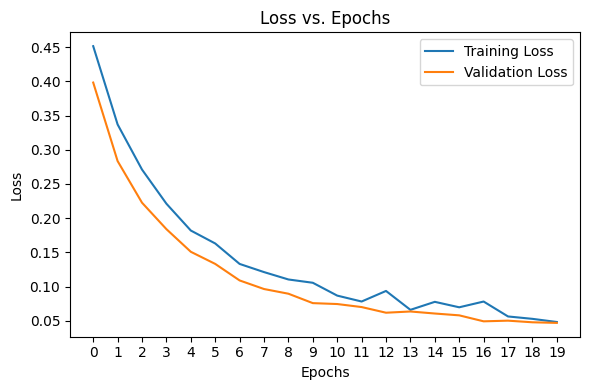

In [53]:
import matplotlib.pyplot as plt

# Loss plot
plt.figure(figsize=(6, 4))

plt.plot(metrics.index, metrics['loss_train'], label='Training Loss')
plt.plot(metrics.index, metrics['loss_valid'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.xticks(range(epochs)) 
plt.legend()

plt.tight_layout()
plt.show()


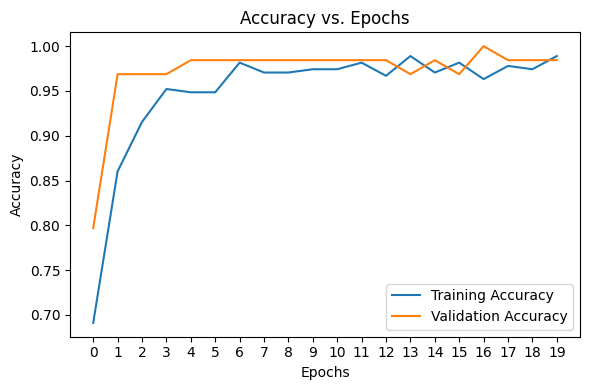

In [54]:
# Accuracy plot
plt.figure(figsize=(6, 4))

plt.plot(metrics.index, metrics['accuracy_train'], label='Training Accuracy')
plt.plot(metrics.index, metrics['accuracy_valid'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xticks(range(epochs))  
plt.legend()

plt.tight_layout()
plt.show()

### Bonus: Run the net on 'new' inputs

We have built and trained a net, and evaluated and visualised its performance. However, how do we now utilise it going forward?

Here we construct some 'new' input data and use our trained net to infer the species. Whilst this is relatively straightforward there is still some work required to transform the outputs from the net to a meaningful result.

In [56]:
from torch import no_grad

# Construct a tensor of inputs to run the model over
demo_input = tensor(
    [
        [42.9, 13.1, 5000.0, 215.0, 0.0],
        [33.6, 11.3, 2000.0, 211.0, 1.0],
    ]
)
print(f"Raw input:\n{demo_input}\n")

# Place model in eval mode and run over inputs with no_grad
model.eval()
with no_grad():
    demo_output = model(demo_input).softmax(dim=1)

# Print the raw output from the net
print(f"Raw output:\n{demo_output}\n")

# Transform the raw output back to human-readable format
print(f"Predicted species:\n{[target_names[val.argmax()] for val in demo_output]}\n")

Raw input:
tensor([[4.2900e+01, 1.3100e+01, 5.0000e+03, 2.1500e+02, 0.0000e+00],
        [3.3600e+01, 1.1300e+01, 2.0000e+03, 2.1100e+02, 1.0000e+00]])

Raw output:
tensor([[1.1300e-03, 8.3503e-04, 9.9804e-01],
        [7.4916e-01, 1.5521e-03, 2.4928e-01]])

Predicted species:
['Gentoo', 'Adelie']



In [57]:
from time import perf_counter

from pandas import DataFrame

epochs = 20

train_metrics, valid_metrics = [], []

for epoch in range(epochs):
    start_time = perf_counter()

    train_loss = train_one_epoch(model, train_loader, optimiser, loss_func)
    train_metrics.append(train_loss)

    valid_loss = validate_one_epoch(model, valid_loader, loss_func)
    valid_metrics.append(valid_loss)

    stop_time = perf_counter()

    print(f"Epoch {epoch} time: {stop_time - start_time:.3f} seconds Train Loss: {round(train_loss['loss'],4)} Val Loss: {round(valid_loss['loss'],4)}")

print("\n")

train_metrics = DataFrame(train_metrics)
valid_metrics = DataFrame(valid_metrics)
metrics = train_metrics.join(valid_metrics, lsuffix="_train", rsuffix="_valid")


Epoch 0 time: 0.119 seconds Train Loss: 0.0571 Val Loss: 0.0467
Epoch 1 time: 0.093 seconds Train Loss: 0.0549 Val Loss: 0.0406
Epoch 2 time: 0.092 seconds Train Loss: 0.0544 Val Loss: 0.042
Epoch 3 time: 0.098 seconds Train Loss: 0.0632 Val Loss: 0.04
Epoch 4 time: 0.094 seconds Train Loss: 0.0536 Val Loss: 0.0374
Epoch 5 time: 0.084 seconds Train Loss: 0.0718 Val Loss: 0.0367
Epoch 6 time: 0.083 seconds Train Loss: 0.0422 Val Loss: 0.0394
Epoch 7 time: 0.090 seconds Train Loss: 0.0461 Val Loss: 0.0347
Epoch 8 time: 0.095 seconds Train Loss: 0.0415 Val Loss: 0.0341
Epoch 9 time: 0.092 seconds Train Loss: 0.0421 Val Loss: 0.0342
Epoch 10 time: 0.091 seconds Train Loss: 0.0294 Val Loss: 0.0359
Epoch 11 time: 0.095 seconds Train Loss: 0.0417 Val Loss: 0.0335
Epoch 12 time: 0.087 seconds Train Loss: 0.0599 Val Loss: 0.0332
Epoch 13 time: 0.085 seconds Train Loss: 0.0321 Val Loss: 0.0333
Epoch 14 time: 0.083 seconds Train Loss: 0.0489 Val Loss: 0.031
Epoch 15 time: 0.089 seconds Train Loss

### Task 11: Visualise some results

Let's do this part together—though feel free to make a start on your own if you have completed the previous exercises.

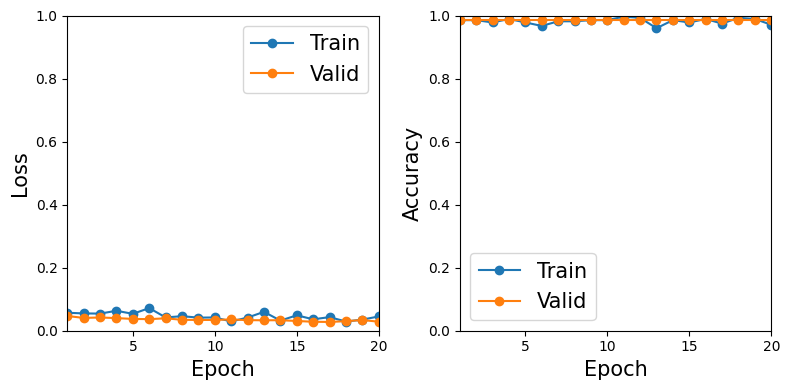

In [58]:
import matplotlib.pyplot as plt
from numpy import linspace


quantities = ["loss", "accuracy"]
splits = ["train", "valid"]

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

for axis, quant in zip(axes.ravel(), quantities):
    for split in splits:
        key = f"{quant}_{split}"
        axis.plot(
            linspace(1, epochs, epochs),
            metrics[key],
            "-o",
            label=split.capitalize(),
        )
    axis.set_ylabel(quant.capitalize(), fontsize=15)

for axis in axes.ravel():
    axis.legend(fontsize=15)
    axis.set_ylim(bottom=0.0, top=1.0)
    axis.set_xlim(left=1, right=epochs)
    axis.set_xlabel("Epoch", fontsize=15)

fig.tight_layout()



### Bonus: Run the net on 'new' inputs

We have built and trained a net, and evaluated and visualised its performance. However, how do we now utilise it going forward?

Here we construct some 'new' input data and use our trained net to infer the species. Whilst this is relatively straightforward there is still some work required to transform the outputs from the net to a meaningful result.

In [59]:
from torch import no_grad

# Construct a tensor of inputs to run the model over
demo_input = tensor(
    [
        [42.9, 13.1, 5000.0, 215.0, 0.0],
        [33.6, 11.3, 2000.0, 211.0, 1.0],
    ]
)
print(f"Raw input:\n{demo_input}\n")

# Place model in eval mode and run over inputs with no_grad
model.eval()
with no_grad():
    demo_output = model(demo_input).softmax(dim=1)

# Print the raw output from the net
print(f"Raw output:\n{demo_output}\n")

# Transform the raw output back to human-readable format
print(f"Predicted species:\n{[target_names[val.argmax()] for val in demo_output]}\n")

Raw input:
tensor([[4.2900e+01, 1.3100e+01, 5.0000e+03, 2.1500e+02, 0.0000e+00],
        [3.3600e+01, 1.1300e+01, 2.0000e+03, 2.1100e+02, 1.0000e+00]])

Raw output:
tensor([[9.8420e-05, 6.0667e-05, 9.9984e-01],
        [6.3560e-01, 5.4130e-04, 3.6386e-01]])

Predicted species:
['Gentoo', 'Adelie']

